In [31]:
import numpy as np 
import pandas as pd 
from datetime import datetime

import plotly.express as px 
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

from scipy.integrate import odeint
from scipy.optimize import minimize

## COVID-19 Cases in the US

Dataset adopted from Center for Systems Science and Engineering (CSSE) at Johns Hopkins University, repository can be found [here](https://github.com/CSSEGISandData/COVID-19)

Here, we will primarily focus on COVID-19 cases in the US, namely from the `csse_covid_19_daily_reports_us` file 

### `csse_covid_19_daily_reports_us` Field Description 

Amongst the 21 columns from the raw, we will be focusing on the columns below: 

- **UID** - Unique Identifier for each row entry. (_should not be necessary, as `Province_State` should be unique in theory_)
- **Province_State** - The name of the State within the USA.
- **Last_Update** - The most recent date the file was pushed.
- **Confirmed** - Aggregated case count for the state.
- **Deaths** - Aggregated death toll for the state.
- **Recovered** - Aggregated Recovered case count for the state.
- **Active** - Aggregated confirmed cases that have not been resolved (Active cases = total cases - total recovered - total deaths). 
- **Incident_Rate** - cases per 100,000 persons.

### Deriving N, S(t), I(t), R(t) 

- **N**:  (`confirmed` x 100,000) / `incident_rate`

- **S(t)**: N - `confirmed`

- **I(t)**: `active`  

- **R(t)**: `recovered` + `deaths`

#### A quick note about `N`

Since `Incident_Rate` = $(Confirmed/N) * 100000$ (_because it gives the cases per 100,000 persons_) 


In [2]:
pd.set_option('display.max_rows', 15)


path = 'csse_covid_19_data/csse_covid_19_daily_reports_us/'

cols = [
    'Province_State',
    'Last_Update',
    'Confirmed',
    'Recovered',
    'Deaths',
    'Active',
    'Incident_Rate'
]

df = pd.read_csv(f'{path}01-01-2021.csv')
df = df[cols]
df.head()

,Province_State,Last_Update,Confirmed,Recovered,Deaths,Active,Incident_Rate
0,Alabama,2021-01-02 05:30:44,365747,202137.0,4872,158738.0,7459.375895
1,Alaska,2021-01-02 05:30:44,47019,7165.0,206,39648.0,6427.355802
2,American Samoa,2021-01-02 05:30:44,0,NaN,0,NaN,0.000000
3,Arizona,2021-01-02 05:30:44,530267,76934.0,9015,444318.0,7285.171274
4,Arkansas,2021-01-02 05:30:44,229442,199247.0,3711,26484.0,7602.945718


In [3]:
# CLEANING 

# lowercase all column names 
df.columns = df.columns.str.lower().str.strip()

# convert last_update to DataTime
df['date'] = df['last_update'].apply(lambda x: pd.to_datetime(x).date())

# N 
df['n'] = (df['confirmed'] * 100000) / df['incident_rate']

# S(t) 
df['s(t)'] = df['n'] - df['confirmed']

# I(t) 
df['i(t)'] = df['active']

# R(t)
df['r(t)'] = df['recovered'] + df['deaths']

df = df.drop(columns=['last_update'])

df.head()

,province_state,confirmed,recovered,deaths,active,incident_rate,date,n,s(t),i(t),r(t)
0,Alabama,365747,202137.0,4872,158738.0,7459.375895,2021-01-02,4903185.0,4537438.0,158738.0,207009.0
1,Alaska,47019,7165.0,206,39648.0,6427.355802,2021-01-02,731545.0,684526.0,39648.0,7371.0
2,American Samoa,0,NaN,0,NaN,0.000000,2021-01-02,NaN,NaN,NaN,NaN
3,Arizona,530267,76934.0,9015,444318.0,7285.171274,2021-01-02,7278717.0,6748450.0,444318.0,85949.0
4,Arkansas,229442,199247.0,3711,26484.0,7602.945718,2021-01-02,3017804.0,2788362.0,26484.0,202958.0


In [4]:
r1 = df[df['province_state'] == 'Alabama']
r2 = df[df['province_state'] == 'California']

pd.concat([r1, r2], axis=0)

,province_state,confirmed,recovered,deaths,active,incident_rate,date,n,s(t),i(t),r(t)
0,Alabama,365747,202137.0,4872,158738.0,7459.375895,2021-01-02,4.903185e+06,4.537438e+06,158738.0,207009.0
5,California,2434971,NaN,26298,NaN,6164.469663,2021-01-02,3.950009e+07,3.706512e+07,NaN,NaN


In [5]:
def get_clean_df(d):
    """Read .csv of COVID data from one date from csse_covid_19_daily_reports_us
       Cleans and selects relevant columns (described above)
       Derives, and adds N, S(t), I(t), R(t), which are defined above
       
       Args: 
        d (datetime): The specific date to 

       Returns: 
        pd.DataFrame(): Final cleaned DataFrame 

        OR 
        
        d, as a string with format 'MM-DD-YYYY', if there is not file with the specified date
       
       """
    

    # SET UP 
    PATH = 'csse_covid_19_data/csse_covid_19_daily_reports_us/'

    COLS = [
        'Province_State',
        'Last_Update',
        'Confirmed',
        'Recovered',
        'Deaths',
        'Active',
        'Incident_Rate'
    ]

    # GET END PATH FOR THE DAY
    month = d.strftime('%m')
    day = d.strftime('%d')
    year = str(d.year)

    END_PATH = f'{month}-{day}-{year}'

    try: 
        # READ CSV 
        df = pd.read_csv(f'{PATH}{END_PATH}.csv')
        df = df[COLS]

        # (elementary) DATA CLEANING, and ADDING/DERIVING NEW COLS FOR SIR
                # lowercase all column names 
        df.columns = df.columns.str.lower().str.strip()

                # convert last_update to DataTime
        df['date'] = df['last_update'].apply(lambda x: pd.to_datetime(x).date())

        df['n'] = (df['confirmed'] * 100000) / df['incident_rate']

        df['s(t)'] = df['n'] - df['confirmed']
               
        df['i(t)'] = df['active']
                
        df['r(t)'] = df['recovered'] + df['deaths']

            # drop redundant columns
        df = df.drop(columns=['last_update'])

        return df
    
    except FileNotFoundError:
        print(f"{END_PATH} not found in csse_covid_19_daily_reports_us/")
        return END_PATH

In [6]:
df_final = pd.DataFrame()
dates = pd.date_range(start="2021-01-01", end="2021-12-10", freq="D")
skipped_dates = []

for date in dates: 
    df_one_date = get_clean_df(date)
    
    if isinstance(df_one_date, pd.DataFrame):
        df_final = pd.concat([df_final, df_one_date], axis=0)
    else: 
        skipped_dates.append(df_one_date)

In [7]:
# lowercase all states 
df_final['province_state'] = df_final['province_state'].str.lower()

### import to .csv

In [8]:
df_final.to_csv('df_all.csv', index=False)

# Final DataFrame, with all dates and states

In [9]:
df_final

,province_state,confirmed,recovered,deaths,active,incident_rate,date,n,s(t),i(t),r(t)
0,alabama,365747,202137.0,4872,158738.0,7459.375895,2021-01-02,4903185.0,4537438.0,158738.0,207009.0
1,alaska,47019,7165.0,206,39648.0,6427.355802,2021-01-02,731545.0,684526.0,39648.0,7371.0
2,american samoa,0,NaN,0,NaN,0.000000,2021-01-02,NaN,NaN,NaN,NaN
3,arizona,530267,76934.0,9015,444318.0,7285.171274,2021-01-02,7278717.0,6748450.0,444318.0,85949.0
4,arkansas,229442,199247.0,3711,26484.0,7602.945718,2021-01-02,3017804.0,2788362.0,26484.0,202958.0
...,...,...,...,...,...,...,...,...,...,...,...
53,virginia,994069,NaN,14895,NaN,11646.263104,2021-12-11,8535519.0,7541450.0,NaN,NaN
54,washington,790412,NaN,9554,NaN,10379.817550,2021-12-11,7614893.0,6824481.0,NaN,NaN
55,west virginia,305418,NaN,5085,NaN,17042.017201,2021-12-11,1792147.0,1486729.0,NaN,NaN
56,wisconsin,1024082,NaN,10385,NaN,17588.554890,2021-12-11,5822434.0,4798352.0,NaN,NaN


# Helper Functions for COVID Data

In [10]:
def get_state(df, state):
    return df[df['province_state'] == state]

# Fitting S(t) and Optimizing $\beta$ and $\gamma$

In [11]:
def sir_model(y, t, beta, gamma):
    s, i, r = y
    dsdt = -beta * s * i
    didt = beta * s * i - gamma * i
    drdt = gamma * i
    return [dsdt, didt, drdt]

def objective(params, s_data, t_data):
    beta, gamma = params
    y0 = [s_data[0], 1 - s_data[0], 0]                  # ASSUME R(0) = 0
    sol = odeint(sir_model, y0, t_data, args=(beta, gamma))
    s_sim = sol[:, 0]
    return np.mean((s_sim - s_data) ** 2)

In [12]:
ny = get_state(df_final, 'new york')
ny['s(t)_prop'] = ny['s(t)'] / ny['n'].iloc[0] 

C:\Users\leena\AppData\Local\Temp\ipykernel_30276\3019987361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny['s(t)_prop'] = ny['s(t)'] / ny['n'].iloc[0]


In [13]:
df = ny.copy() # to make generalizing this pipline easier later

t_data = np.arange(len(df))         # time
s_data = df['s(t)_prop'].values     # observed s(t)

In [14]:
# initial guesses and bounds
initial_guess = [0.5, 0.1]
bounds = [(0, 2), (0, 2)]

# minimize objective funct
result = minimize(lambda p: objective(p, s_data, t_data), initial_guess, bounds=bounds)

# get parameters and R0
beta_fit, gamma_fit = result.x
R0 = beta_fit / gamma_fit

In [15]:
# simulate with SIR model with fitted params 
y0_fit = [s_data[0], 1 - s_data[0], 0]
sir_sol = odeint(sir_model, y0_fit, t_data, args=(beta_fit, gamma_fit))
s_sim = sir_sol[:, 0]

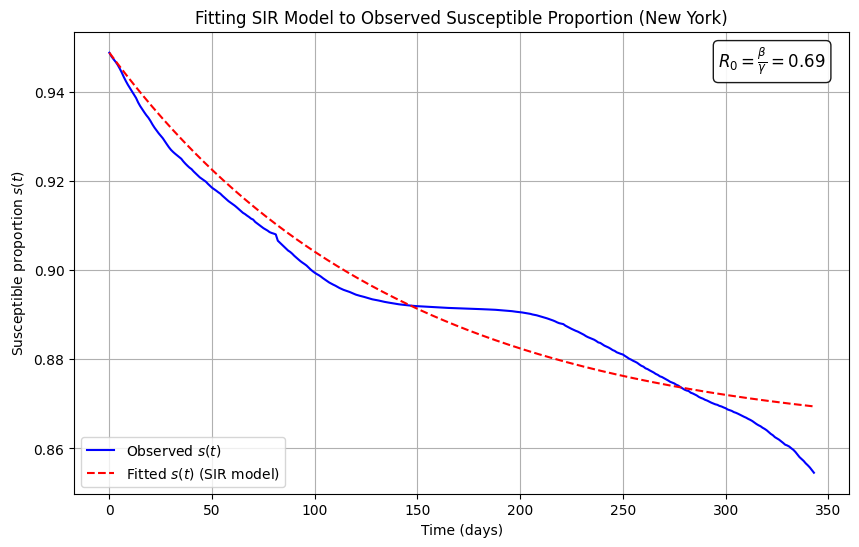

In [16]:
# PLOTTING 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_data, s_data, 'b-', label='Observed $s(t)$')
ax.plot(t_data, s_sim, 'r--', label='Fitted $s(t)$ (SIR model)')


# annotate R0 
textstr = r'$R_0 = \frac{{\beta}}{{\gamma}} = %.2f$' % R0
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
ax.text(0.97, 0.97, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=props)


ax.set_title('Fitting SIR Model to Observed Susceptible Proportion (New York)')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Susceptible proportion $s(t)$')
ax.legend()
ax.grid()

plt.show()

In [ ]:
# save figure 
filename = 'ny_s(t)_fit'
full_path = f'C:/Users/leena/math111a/plots/{filename}.png'
fig.savefig(full_path)
print('Plot saved')

Plot saved


## Saving DataFrame Images for Report

Plot saved


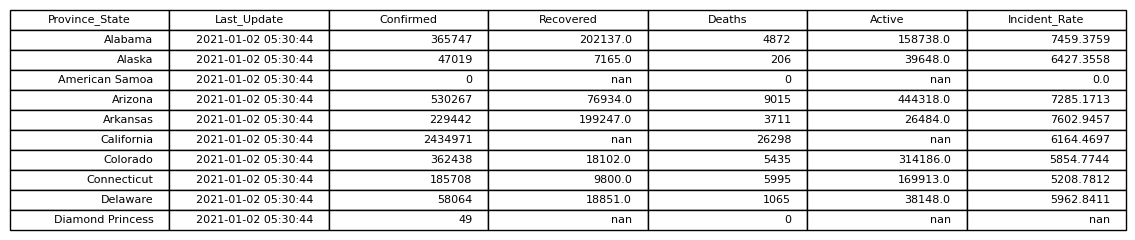

In [26]:
# raw for one month
path = 'csse_covid_19_data/csse_covid_19_daily_reports_us/'
cols = [
    'Province_State',
    'Last_Update',
    'Confirmed',
    'Recovered',
    'Deaths',
    'Active',
    'Incident_Rate'
]

df_raw = pd.read_csv(f'{path}01-01-2021.csv')
df_raw = df[cols]
raw_head = df_raw.head(10)
raw_head = raw_head.round(4)


fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')
table = ax.table(cellText=raw_head.values, colLabels=raw_head.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)

plt.savefig("covid_raw_df.png", bbox_inches='tight', dpi=300)
print('Plot saved')


Plot saved


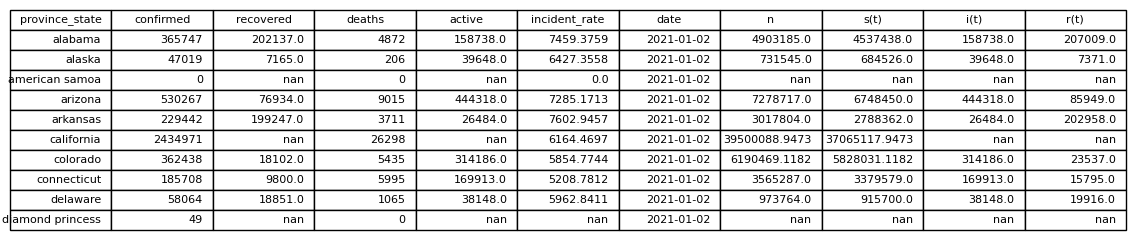

In [30]:
# cleaned, for one month
clean_head = df_final.head(10)
clean_head = clean_head.round(4)


fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')
table = ax.table(cellText=clean_head.values, colLabels=clean_head.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)

plt.savefig("covid_clean_df.png", bbox_inches='tight', dpi=300)
print('Plot saved')